Tutorial tirado de https://towardsdatascience.com/deep-clustering-for-financial-market-segmentation-2a41573618cf

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ccdata/CC GENERAL.csv


In [96]:
from time import time
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [4]:
data = pd.read_csv('/kaggle/input/ccdata/CC GENERAL.csv')
data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [5]:
data_x = data.drop(['CUST_ID'], axis=1)

In [6]:
# Re-escala tudo para o intervalo entre 0 e 1
from sklearn.preprocessing import MinMaxScaler
numeric_columns = data_x.columns.values.tolist()
scaler = MinMaxScaler()
data_x[numeric_columns] = scaler.fit_transform(data_x[numeric_columns])
data_x.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,0.002148,0.818182,0.001945,0.000000,0.00424,0.000000,0.166667,0.000000,0.083333,0.000000,0.00000,0.005587,0.031720,0.003979,0.001826,0.000000,1.0
1,0.168169,0.909091,0.000000,0.000000,0.00000,0.136685,0.000000,0.000000,0.000000,0.166667,0.03252,0.000000,0.232053,0.080893,0.014034,0.222222,1.0
2,0.131026,1.000000,0.015766,0.018968,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.033520,0.248748,0.012264,0.008210,0.000000,1.0
3,0.087521,0.636364,0.030567,0.036775,0.00000,0.004366,0.083333,0.083333,0.000000,0.055555,0.00813,0.002793,0.248748,0.000000,NaN,0.000000,1.0
4,0.042940,1.000000,0.000326,0.000393,0.00000,0.000000,0.083333,0.083333,0.000000,0.000000,0.00000,0.002793,0.038397,0.013374,0.003204,0.000000,1.0


In [7]:

# Lidando com dados faltando
data_x.isnull().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [8]:
# Completando os dados que faltam com zero
data_x.fillna(0, inplace=True)

**    Implementation of the DEC Method in Keras
**    
    Step 1: Estimating the number of clusters
    Step 2: Creating and training a K-means model
    Step 3: Creating and training an autoencoder
    Step 4: Implementing DEC Soft Labeling
    Step 5: Creating a new DEC model
    Step 6: Training the New DEC Model
    Step 7: Using the Trained DEC Model for Predicting Clustering Classes
    Step 8: Jointly Refining DEC Model
    Step 9: Using Refined DEC Model for Predicting Clustering Classes
    Step 10: Comparing with K-means

In [16]:
# Creating and training autoencoder
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected symmetric auto-encoder model.
  
    dims: list of the sizes of layers of encoder like [500, 500, 2000, 10]. 
          dims[0] is input dim, dims[-1] is size of the latent hidden layer.

    act: activation function
    
    return:
        (autoencoder_model, encoder_model): Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    
    input_data = Input(shape=(dims[0],), name='input')
    x = input_data
    
    # internal layers of encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # latent hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)

    x = encoded
    # internal layers of decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # decoder output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    
    decoded = x
    
    autoencoder_model = Model(inputs=input_data, outputs=decoded, name='autoencoder')
    encoder_model     = Model(inputs=input_data, outputs=encoded, name='encoder')
    
    return autoencoder_model, encoder_model


In [17]:
data_x.dtypes

BALANCE                             float64
BALANCE_FREQUENCY                   float64
PURCHASES                           float64
ONEOFF_PURCHASES                    float64
INSTALLMENTS_PURCHASES              float64
CASH_ADVANCE                        float64
PURCHASES_FREQUENCY                 float64
ONEOFF_PURCHASES_FREQUENCY          float64
PURCHASES_INSTALLMENTS_FREQUENCY    float64
CASH_ADVANCE_FREQUENCY              float64
CASH_ADVANCE_TRX                    float64
PURCHASES_TRX                       float64
CREDIT_LIMIT                        float64
PAYMENTS                            float64
MINIMUM_PAYMENTS                    float64
PRC_FULL_PAYMENT                    float64
TENURE                              float64
dtype: object

In [18]:
x = data_x.values
x.shape

(8950, 17)

In [20]:
# Estimating the number of clusters

for num_clusters in range(2,10):
    clusterer = KMeans(n_clusters=num_clusters, n_jobs=4)
    preds = clusterer.fit_predict(x)
    # centers = clusterer.cluster_centers_
    score = silhouette_score(x, preds, metric='euclidean')
    print('For n_clusters = {}, Kmeans silhouette score is {}'.format(num_clusters, score))
    

For n_clusters = 2, Kmeans silhouette score is 0.38671905661700495
For n_clusters = 3, Kmeans silhouette score is 0.37239144184726347
For n_clusters = 4, Kmeans silhouette score is 0.3215104946972683
For n_clusters = 5, Kmeans silhouette score is 0.3195084713077689
For n_clusters = 6, Kmeans silhouette score is 0.32207990265603786
For n_clusters = 7, Kmeans silhouette score is 0.33803179266305255
For n_clusters = 8, Kmeans silhouette score is 0.3164670586570084
For n_clusters = 9, Kmeans silhouette score is 0.33435939368759066


In [21]:
n_clusters = 3 
n_epochs   = 100
batch_size = 128

In [22]:
# Creating and Training K-means model
kmeans = KMeans(n_clusters=n_clusters, n_jobs=4)
y_pred_kmeans = kmeans.fit_predict(x) #x == valores do csv

In [23]:

# Tamanho das camadas
# configuração generica do autoencoder da rede neural de qualquer dataset
dims = [x.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale=1./3., mode='fan_in', distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = n_epochs
batch_size = batch_size
save_dir='/kaggle/output'

In [24]:
dims

[17, 500, 500, 2000, 10]

In [25]:
init

In [26]:
# Criação do modelo de autoencoder

autoencoder, encoder = autoencoder(dims, init=init)

In [27]:
from keras.utils import plot_model
from IPython.display import Image

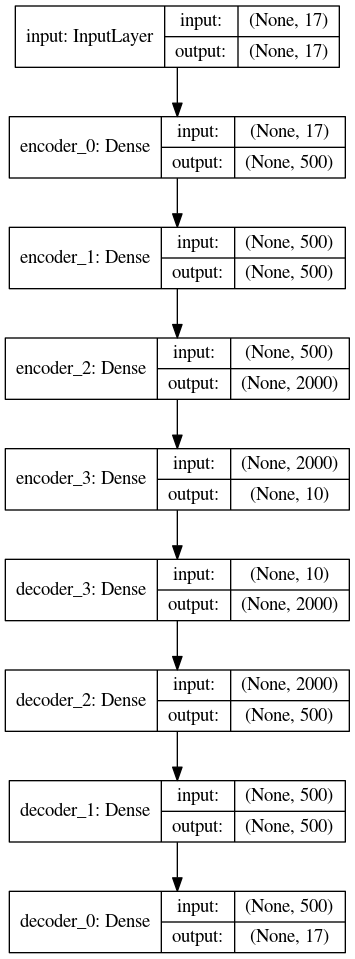

In [28]:
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
Image(filename='autoencoder.png')

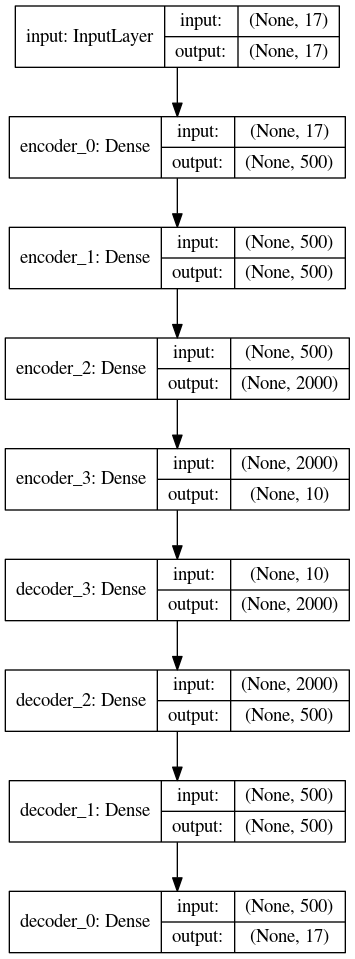

In [29]:
plot_model(autoencoder, to_file='encoder.png', show_shapes=True)
Image(filename='encoder.png')

In [31]:
# Treinamento do autoencoder
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x,x, batch_size=batch_size, epochs=pretrain_epochs)
autoencoder.save_weights('ae_weights.h5')

Epoch 1/100
8950/8950 [==============================] - 2s 254us/step - loss: 8.5351e-05
Epoch 2/100
8950/8950 [==============================] - 2s 239us/step - loss: 8.6284e-05
Epoch 3/100
8950/8950 [==============================] - 2s 235us/step - loss: 8.9200e-05
Epoch 4/100
8950/8950 [==============================] - 2s 225us/step - loss: 8.5905e-05
Epoch 5/100
8950/8950 [==============================] - 2s 241us/step - loss: 8.8312e-05
Epoch 6/100
8950/8950 [==============================] - 2s 243us/step - loss: 8.3342e-05
Epoch 7/100
8950/8950 [==============================] - 2s 243us/step - loss: 8.7800e-05
Epoch 8/100
8950/8950 [==============================] - 2s 241us/step - loss: 8.4360e-05
Epoch 9/100
8950/8950 [==============================] - 2s 227us/step - loss: 8.4138e-05
Epoch 10/100
8950/8950 [==============================] - 2s 234us/step - loss: 8.1427e-05
Epoch 11/100
8950/8950 [==============================] - 2s 269us/step - loss: 8.3702e-05
Epoch 12

8950/8950 [==============================] - 2s 238us/step - loss: 4.9662e-05
Epoch 92/100
8950/8950 [==============================] - 2s 242us/step - loss: 4.9170e-05
Epoch 93/100
8950/8950 [==============================] - 3s 329us/step - loss: 4.8037e-05
Epoch 94/100
8950/8950 [==============================] - 3s 379us/step - loss: 4.9442e-05
Epoch 95/100
8950/8950 [==============================] - 3s 292us/step - loss: 4.8265e-05
Epoch 96/100
8950/8950 [==============================] - 2s 256us/step - loss: 4.8548e-05
Epoch 97/100
8950/8950 [==============================] - 2s 243us/step - loss: 4.8629e-05
Epoch 98/100
8950/8950 [==============================] - 2s 241us/step - loss: 4.7321e-05
Epoch 99/100
8950/8950 [==============================] - 2s 243us/step - loss: 5.1320e-05
Epoch 100/100
8950/8950 [==============================] - 2s 241us/step - loss: 4.5855e-05


In [32]:
autoencoder.load_weights('ae_weights.h5')

In [33]:
class ClusteringLayer(Layer):
    '''
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    '''

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(name='clusters', shape=(self.n_clusters, input_dim), initializer='glorot_uniform') 
        
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        ''' 
        student t-distribution, as used in t-SNE algorithm.
        It measures the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
       
        inputs: the variable containing data, shape=(n_samples, n_features)
        
        Return: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        '''
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure all of the values of each sample sum up to 1.
        
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [37]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

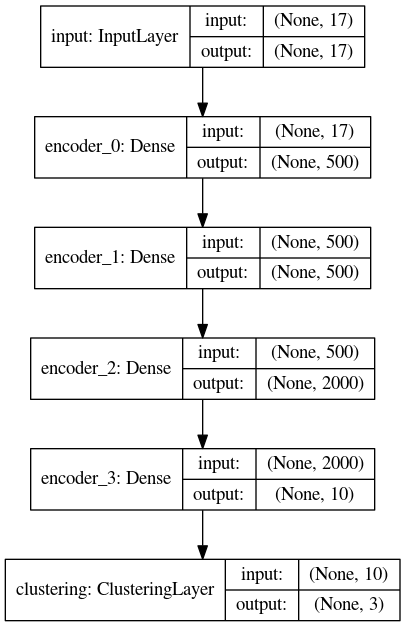

In [38]:
plot_model(model, to_file='model.png', show_shapes=True)
Image(filename='model.png')

In [39]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')


In [40]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))

In [41]:
y_pred_last = np.copy(y_pred)

In [43]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

**DEEP CLUSTERING**

In [44]:


# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T



In [45]:
loss = 0
index = 0
maxiter = 1000
update_interval = 100
index_array = np.arange(x.shape[0])

In [46]:
tol = 0.001

In [49]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)
    
    idx = index_array[index*batch_size : min((index+1)*batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0
    print ('ite: {}'.format(str(ite)))
    
model.save_weights('DEC_model_final.h5')

ite: 0
ite: 1
ite: 2
ite: 3
ite: 4
ite: 5
ite: 6
ite: 7
ite: 8
ite: 9
ite: 10
ite: 11
ite: 12
ite: 13
ite: 14
ite: 15
ite: 16
ite: 17
ite: 18
ite: 19
ite: 20
ite: 21
ite: 22
ite: 23
ite: 24
ite: 25
ite: 26
ite: 27
ite: 28
ite: 29
ite: 30
ite: 31
ite: 32
ite: 33
ite: 34
ite: 35
ite: 36
ite: 37
ite: 38
ite: 39
ite: 40
ite: 41
ite: 42
ite: 43
ite: 44
ite: 45
ite: 46
ite: 47
ite: 48
ite: 49
ite: 50
ite: 51
ite: 52
ite: 53
ite: 54
ite: 55
ite: 56
ite: 57
ite: 58
ite: 59
ite: 60
ite: 61
ite: 62
ite: 63
ite: 64
ite: 65
ite: 66
ite: 67
ite: 68
ite: 69
ite: 70
ite: 71
ite: 72
ite: 73
ite: 74
ite: 75
ite: 76
ite: 77
ite: 78
ite: 79
ite: 80
ite: 81
ite: 82
ite: 83
ite: 84
ite: 85
ite: 86
ite: 87
ite: 88
ite: 89
ite: 90
ite: 91
ite: 92
ite: 93
ite: 94
ite: 95
ite: 96
ite: 97
ite: 98
ite: 99
ite: 100
ite: 101
ite: 102
ite: 103
ite: 104
ite: 105
ite: 106
ite: 107
ite: 108
ite: 109
ite: 110
ite: 111
ite: 112
ite: 113
ite: 114
ite: 115
ite: 116
ite: 117
ite: 118
ite: 119
ite: 120
ite: 121
ite: 122
ite

ite: 928
ite: 929
ite: 930
ite: 931
ite: 932
ite: 933
ite: 934
ite: 935
ite: 936
ite: 937
ite: 938
ite: 939
ite: 940
ite: 941
ite: 942
ite: 943
ite: 944
ite: 945
ite: 946
ite: 947
ite: 948
ite: 949
ite: 950
ite: 951
ite: 952
ite: 953
ite: 954
ite: 955
ite: 956
ite: 957
ite: 958
ite: 959
ite: 960
ite: 961
ite: 962
ite: 963
ite: 964
ite: 965
ite: 966
ite: 967
ite: 968
ite: 969
ite: 970
ite: 971
ite: 972
ite: 973
ite: 974
ite: 975
ite: 976
ite: 977
ite: 978
ite: 979
ite: 980
ite: 981
ite: 982
ite: 983
ite: 984
ite: 985
ite: 986
ite: 987
ite: 988
ite: 989
ite: 990
ite: 991
ite: 992
ite: 993
ite: 994
ite: 995
ite: 996
ite: 997
ite: 998
ite: 999


In [50]:
model.load_weights('DEC_model_final.h5')

In [51]:
#Eval 
q = model.predict(x, verbose=0)
p = target_distribution(q)

y_pred = q.argmax(1)

In [52]:
data_all = data_x.copy()

In [53]:
data_all

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,0.002148,0.818182,0.001945,0.000000,0.004240,0.000000,0.166667,0.000000,0.083333,0.000000,0.00000,0.005587,0.031720,0.003979,0.001826,0.000000,1.0
1,0.168169,0.909091,0.000000,0.000000,0.000000,0.136685,0.000000,0.000000,0.000000,0.166667,0.03252,0.000000,0.232053,0.080893,0.014034,0.222222,1.0
2,0.131026,1.000000,0.015766,0.018968,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.033520,0.248748,0.012264,0.008210,0.000000,1.0
3,0.087521,0.636364,0.030567,0.036775,0.000000,0.004366,0.083333,0.083333,0.000000,0.055555,0.00813,0.002793,0.248748,0.000000,0.000000,0.000000,1.0
4,0.042940,1.000000,0.000326,0.000393,0.000000,0.000000,0.083333,0.083333,0.000000,0.000000,0.00000,0.002793,0.038397,0.013374,0.003204,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,0.001496,1.000000,0.005936,0.000000,0.012939,0.000000,1.000000,0.000000,0.833333,0.000000,0.00000,0.016760,0.031720,0.006419,0.000640,0.500000,0.0
8946,0.001007,1.000000,0.006118,0.000000,0.013333,0.000000,1.000000,0.000000,0.833333,0.000000,0.00000,0.016760,0.031720,0.005439,0.000000,0.000000,0.0
8947,0.001229,0.833333,0.002945,0.000000,0.006418,0.000000,0.833333,0.000000,0.666667,0.000000,0.00000,0.013966,0.031720,0.001602,0.001078,0.250000,0.0
8948,0.000707,0.833333,0.000000,0.000000,0.000000,0.000776,0.000000,0.000000,0.000000,0.111111,0.01626,0.000000,0.015025,0.001036,0.000729,0.250000,0.0


In [58]:
data_all['cluster'] = y_pred

In [59]:
data_all.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,0.002148,0.818182,0.001945,0.000000,0.00424,0.000000,0.166667,0.000000,0.083333,0.000000,0.00000,0.005587,0.031720,0.003979,0.001826,0.000000,1.0,1
1,0.168169,0.909091,0.000000,0.000000,0.00000,0.136685,0.000000,0.000000,0.000000,0.166667,0.03252,0.000000,0.232053,0.080893,0.014034,0.222222,1.0,1
2,0.131026,1.000000,0.015766,0.018968,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.033520,0.248748,0.012264,0.008210,0.000000,1.0,2
3,0.087521,0.636364,0.030567,0.036775,0.00000,0.004366,0.083333,0.083333,0.000000,0.055555,0.00813,0.002793,0.248748,0.000000,0.000000,0.000000,1.0,1
4,0.042940,1.000000,0.000326,0.000393,0.00000,0.000000,0.083333,0.083333,0.000000,0.000000,0.00000,0.002793,0.038397,0.013374,0.003204,0.000000,1.0,1


In [61]:
data_all['cluster'].value_counts()

1    3800
0    3075
2    2075
Name: cluster, dtype: int64

In [63]:
x_embedded = TSNE(n_components=2).fit_transform(x)
x_embedded.shape

(8950, 2)

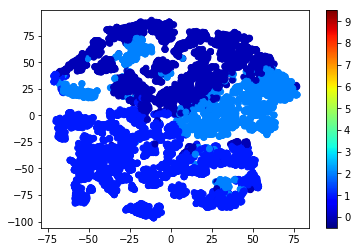

In [64]:
vis_x = x_embedded[:, 0]
vis_y = x_embedded[:, 1]
plt.scatter(vis_x, vis_y, c=y_pred, cmap=plt.cm.get_cmap("jet", 256))
plt.colorbar(ticks=range(256))
plt.clim(-0.5, 9.5)
plt.show()

In [65]:
y_pred_kmeans.shape

(8950,)

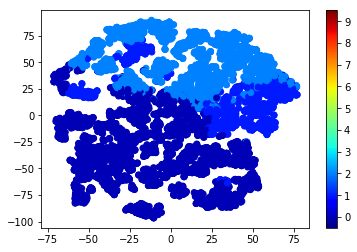

In [69]:
plt.scatter(vis_x, vis_y, c=y_pred_kmeans, cmap=plt.cm.get_cmap('jet', 256))
plt.colorbar(ticks=range(100))
plt.clim(-0.5, 9.5)
plt.show()

In [71]:
score = silhouette_score(x, y_pred_kmeans, metric='euclidean')
print ("For n_clusters = {}, Kmeans silhouette score is {})".format(n_clusters, score))

For n_clusters = 3, Kmeans silhouette score is 0.372350277731719)


In [72]:
score = silhouette_score (x, y_pred, metric='euclidean')
print ("For n_clusters = {}, Deep clustering silhouette score is {})".format(n_clusters, score))

For n_clusters = 3, Deep clustering silhouette score is 0.3199039477090198)


In [73]:
for num_clusters in range(2,10):
    clusterer = KMeans(n_clusters=num_clusters, n_jobs=4)
    preds = clusterer.fit_predict(x)
    # centers = clusterer.cluster_centers_
    score = silhouette_score (x, preds, metric='euclidean')
    print ("For n_clusters = {}, Kmeans silhouette score is {})".format(num_clusters, score))

For n_clusters = 2, Kmeans silhouette score is 0.38671905661700495)
For n_clusters = 3, Kmeans silhouette score is 0.37239463623145763)
For n_clusters = 4, Kmeans silhouette score is 0.3215104946972683)
For n_clusters = 5, Kmeans silhouette score is 0.3191625864388025)
For n_clusters = 6, Kmeans silhouette score is 0.33420938598094196)
For n_clusters = 7, Kmeans silhouette score is 0.3361290094459726)
For n_clusters = 8, Kmeans silhouette score is 0.3164670586570084)
For n_clusters = 9, Kmeans silhouette score is 0.3340553328894084)


In [74]:
# Need to re-run autoencoder function declaration!!!
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_data = Input(shape=(dims[0],), name='input')
    x = input_data
    
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_data, outputs=decoded, name='AE'), Model(inputs=input_data, outputs=encoded, name='encoder')

In [78]:
autoencoder.load_weights('ae_weights.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=[clustering_layer, autoencoder.output])

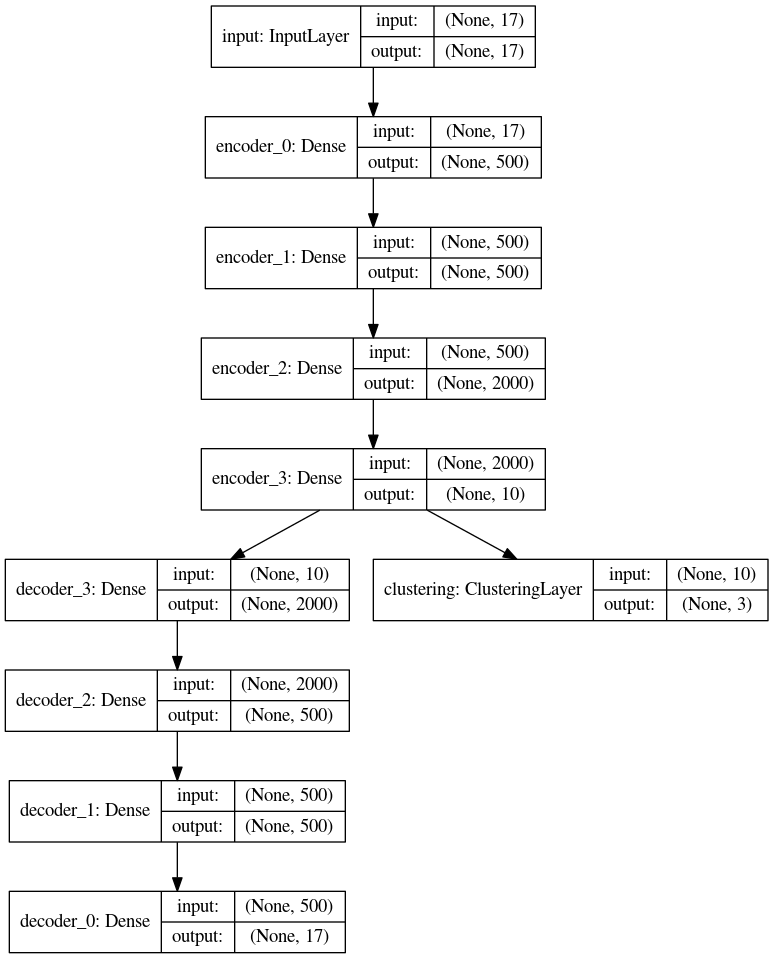

In [80]:

plot_model(model, to_file='model.png', show_shapes=True)
Image(filename='model.png')



In [81]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

In [82]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer=pretrain_optimizer)

In [83]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights('b_DEC_model_final.h5')

In [85]:
model.load_weights('b_DEC_model_final.h5')

In [86]:
# evaluation of model prediction
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)

# evaluate the clustering performance
y_pred = q.argmax(1)

In [87]:
score = silhouette_score(x, y_pred, metric='euclidean')
print ("For n_clusters = {}, Deep clustering silhouette score is {})".format(n_clusters, score))

For n_clusters = 3, Deep clustering silhouette score is 0.32698923699485277)


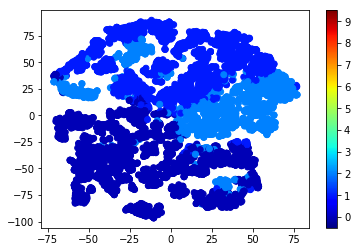

In [88]:
plt.scatter(vis_x, vis_y, c=y_pred, cmap=plt.cm.get_cmap("jet", 256))
plt.colorbar(ticks=range(256))
plt.clim(-0.5, 9.5)
plt.show()

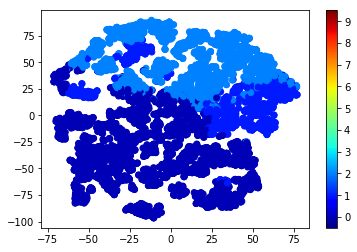

In [89]:


plt.scatter(vis_x, vis_y, c=y_pred_kmeans, cmap=plt.cm.get_cmap("jet", 256))
plt.colorbar(ticks=range(256))
plt.clim(-0.5, 9.5)
plt.show()



In [90]:
data_all['cluster'] = y_pred

In [91]:
data_all['cluster'].value_counts()

0    3840
1    2988
2    2122
Name: cluster, dtype: int64

In [92]:
data_cluster_0 = data_all[data_all['cluster'] == 0]

In [93]:
data_cluster_0.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
count,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.000000,3840.0
mean,0.095665,0.841483,0.003894,0.004143,0.000985,0.031474,0.079917,0.054678,0.023974,0.136007,0.039007,0.004006,0.135123,0.029241,0.011315,0.036402,0.912717,0.0
std,0.108571,0.274110,0.012013,0.014197,0.004538,0.049184,0.105136,0.084948,0.065062,0.141432,0.062436,0.007299,0.110563,0.051933,0.029809,0.117983,0.225566,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.018083,0.818182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048414,0.006166,0.002345,0.000000,1.000000,0.0
50%,0.061340,1.000000,0.000000,0.000000,0.000000,0.011718,0.000000,0.000000,0.000000,0.111111,0.016260,0.000000,0.098497,0.013060,0.005149,0.000000,1.000000,0.0
75%,0.129778,1.000000,0.003319,0.002880,0.000000,0.042753,0.166667,0.083333,0.000000,0.222222,0.048780,0.005587,0.198664,0.030189,0.011125,0.000000,1.000000,0.0
max,0.765707,1.000000,0.365929,0.440247,0.133333,0.555698,0.416667,0.333333,0.333333,1.000000,1.000000,0.094972,0.766277,1.000000,0.798778,1.000000,1.000000,0.0


In [94]:


data_cluster_1 = data_all[data_all['cluster'] == 1]
data_cluster_1.describe()



,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
count,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.0
mean,0.054358,0.876223,0.018001,0.004340,0.031403,0.010235,0.802031,0.062442,0.752692,0.042796,0.012394,0.048608,0.125407,0.024750,0.011288,0.248082,0.920627,1.0
std,0.092362,0.229821,0.022930,0.011166,0.041670,0.031078,0.225233,0.100748,0.243871,0.097429,0.035431,0.052480,0.105863,0.036435,0.038217,0.344951,0.225031,0.0
min,0.000000,0.000000,0.000245,0.000000,0.000533,0.000000,0.083333,0.000000,0.083333,0.000000,0.000000,0.000000,0.008347,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.002233,0.833333,0.005648,0.000000,0.010634,0.000000,0.583333,0.000000,0.545455,0.000000,0.000000,0.022346,0.048414,0.006682,0.001840,0.000000,1.000000,1.0
50%,0.012465,1.000000,0.010766,0.000000,0.019605,0.000000,0.909091,0.000000,0.833333,0.000000,0.000000,0.033520,0.088898,0.013901,0.002425,0.000000,1.000000,1.0
75%,0.067335,1.000000,0.022031,0.003420,0.037823,0.000411,1.000000,0.083333,1.000000,0.055555,0.008130,0.055866,0.165275,0.029176,0.008671,0.454545,1.000000,1.0
max,0.856208,1.000000,0.458813,0.155678,1.000000,0.557282,1.000000,0.416667,1.000000,0.666667,0.577236,0.969274,0.766277,0.800994,1.000000,1.000000,1.000000,1.0


In [95]:
data_cluster_2 = data_all[data_all['cluster'] == 2]
data_cluster_2.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
count,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.000000,2122.0
mean,0.096845,0.943509,0.053888,0.047693,0.031056,0.016218,0.794197,0.667039,0.433841,0.073619,0.023363,0.097607,0.204715,0.056355,0.009665,0.233127,0.930412,2.0
std,0.124203,0.140389,0.073379,0.070813,0.058189,0.047206,0.232505,0.255110,0.384749,0.135229,0.059934,0.102964,0.141914,0.079581,0.016629,0.352759,0.215198,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008347,0.000000,0.000000,0.000000,0.000000,2.0
25%,0.014040,1.000000,0.016728,0.015488,0.000000,0.000000,0.583333,0.446969,0.000000,0.000000,0.000000,0.033520,0.098497,0.016401,0.002330,0.000000,1.000000,2.0
50%,0.049183,1.000000,0.033223,0.028561,0.010734,0.000000,0.916667,0.666667,0.416667,0.000000,0.000000,0.064246,0.181970,0.032762,0.003882,0.000000,1.000000,2.0
75%,0.130719,1.000000,0.064346,0.054968,0.037809,0.010482,1.000000,0.916667,0.833333,0.111111,0.016260,0.122905,0.282137,0.065565,0.011196,0.363636,1.000000,2.0
max,1.000000,1.000000,1.000000,1.000000,0.688764,1.000000,1.000000,1.000000,1.000000,0.777778,1.000000,1.000000,1.000000,0.925261,0.277923,1.000000,1.000000,2.0


In [97]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)

x_pca.shape

(8950, 2)

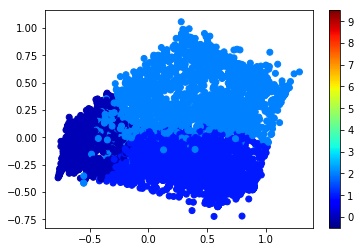

In [98]:


vis_x = x_pca[:, 0]
vis_y = x_pca[:, 1]
plt.scatter(vis_x, vis_y, c=y_pred, cmap=plt.cm.get_cmap("jet", 256))
plt.colorbar(ticks=range(256))
plt.clim(-0.5, 9.5)
plt.show()

